In [16]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os 
from functions import *
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.patches as mpatches

# Load dataset

In [17]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
geo_merged = pd.read_csv('../data/IMdata/merged_rpkm.csv')
regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
IM_list = list(S.columns)
sample_list = list(A.columns)
empty_IMs = ['3', '13', '22', '24', '29', '37', '50', '51']
A = A.drop( [int(x) for x in empty_IMs])

IM_annotation = pd.read_csv('../data/IMdata/IM_annotation.csv')
IM_names = []
for i in range(len(IM_annotation.index)):
    if list(IM_annotation['Regulator annotation'])[i] == '_':
        IM_names.append('IM-'+str(list(IM_annotation['IM'])[i]))
    else:
        IM_names.append(list(IM_annotation['Regulator annotation'])[i].strip())

# pH response

<Axes: >

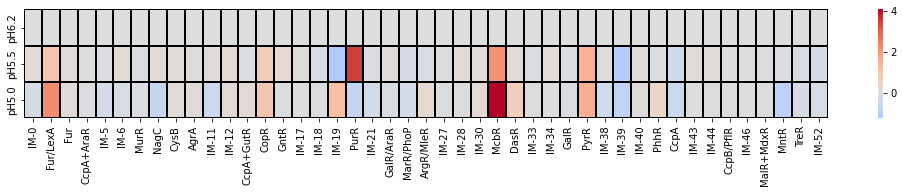

In [18]:
A_pH = A[A.columns[0:6]]
Act_pH = pd.DataFrame(zip( A_pH[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1), A_pH[['wt_pH5.5_1','wt_pH5.5_2']].mean(axis=1),
                         A_pH[['wt_pH5.0_1','wt_pH5.0_2']].mean(axis=1)), columns=['pH6.2','pH5.5','pH5.0'])
Act_pH = Act_pH.T
Act_pH.columns = IM_names
fig, ax = plt.subplots(1,1,figsize=(18,2))
sns.heatmap( Act_pH, xticklabels=True, 
            linecolor='black',linewidths=1.5,cmap="coolwarm",center=0, ax = ax)
# plt.savefig('../../../../ICA_LP/Figures/Amatrix_pH.svg',format='svg',dpi=150)

Text(0, 0.5, 'RPKM')

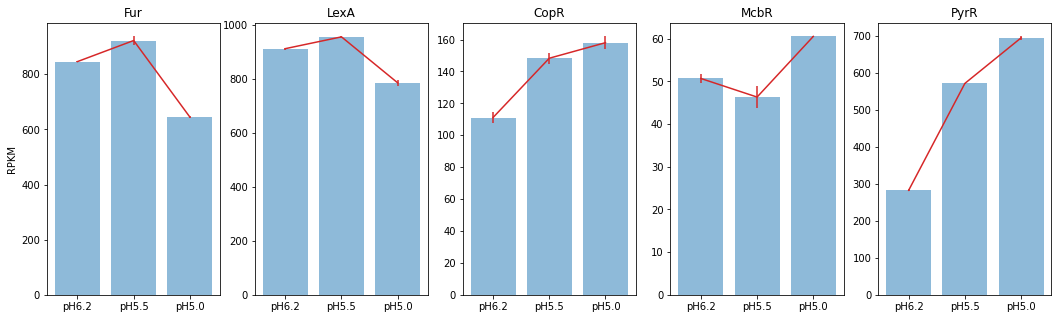

In [19]:
fig, axs = plt.subplots(1,5,figsize=(18,5))
g2plot = {'Fur':'lp_3247','LexA':'lp_2063','CopR':'lp_3365','McbR':'lp_2772','PyrR':'lp_2704'}
conditions = ['wt_pH6.2_1', 'wt_pH6.2_2', 'wt_pH5.5_1', 'wt_pH5.5_2','wt_pH5.0_1', 'wt_pH5.0_2']
for i in range(len(g2plot.keys())):
    gname = list( g2plot.keys() )[i]
    g_tag = g2plot[gname]
    temp_pd = geo_merged.loc[geo_merged['locus_tag']== g_tag].reset_index()
    x = [(list(temp_pd['wt_pH6.2_1'])[0] + list(temp_pd['wt_pH6.2_2'])[0] )/2,\
        (list(temp_pd['wt_pH5.5_1'])[0] + list(temp_pd['wt_pH5.5_2'])[0] )/2, \
        (list(temp_pd['wt_pH5.0_1'])[0] + list(temp_pd['wt_pH5.0_2'])[0] )/2]
    std = [ np.std( [list(temp_pd['wt_pH6.2_1'])[0], list(temp_pd['wt_pH6.2_2'])[0]] ),\
        np.std( [list(temp_pd['wt_pH5.5_1'])[0], list(temp_pd['wt_pH5.5_2'])[0]]), \
        np.std( [list(temp_pd['wt_pH5.0_1'])[0], list(temp_pd['wt_pH5.0_2'])[0]]) ]
    axs[i].bar( ['pH6.2','pH5.5','pH5.0'], x, color='tab:blue', alpha=0.5)
    axs[i].errorbar(['pH6.2','pH5.5','pH5.0'], x, yerr=std,color="tab:red")
    axs[i].set_title(gname)
axs[0].set_ylabel('RPKM')
# plt.savefig('../../../../ICA_LP/Figures/TF_exp_pH.svg',format='svg',dpi=150)

# QS and Different carbon sources

In [20]:
qs_conditions = ['wt_QS-_1hr','wt_QS-_4hr','wt_QS-_7hr','wt_QS+_1hr','wt_QS+_4hr','wt_QS+_7hr']
cc_conditions = []
conversion = {}
for name in list( A.columns[6:6+37-1] ):
    sample = name.split('3OC_')[1].strip()
    if 'm' in sample:
        cond = 'wt_QS-_'+str( sample.split('m')[1][0] )+'hr'
    elif 'p' in sample:
        cond = 'wt_QS+_'+str( sample.split('p')[1][0] )+'hr'
    
    new_name = cond+'_'+sample[0]
    if 'b' in sample:
        new_name = new_name + 'b'
    conversion[name] = new_name 
for name in list( A.columns[-22:] ):
    cc_conditions.append(name.split('_rep')[0])
    conversion[name] = name.replace('rep','')
cc_conditions = list(set(cc_conditions))  
A = A.rename(columns = conversion)

In [38]:
# merge QS and carbon activities
Act_dict = {}
for cond in qs_conditions:
    Act_dict[cond.replace('wt_','')] = list( A[[cond+'_1',cond+'_2',cond+'_3',cond+'_1b',cond+'_2b',cond+'_3b']].mean(axis=1) )
for cond in cc_conditions:
    Act_dict[cond.replace('wt_','')] = list( A[[cond+'_1',cond+'_2']].mean(axis=1) )

A_merge = pd.DataFrame(Act_dict )
A_merge = A_merge.T
A_merge.columns = IM_names

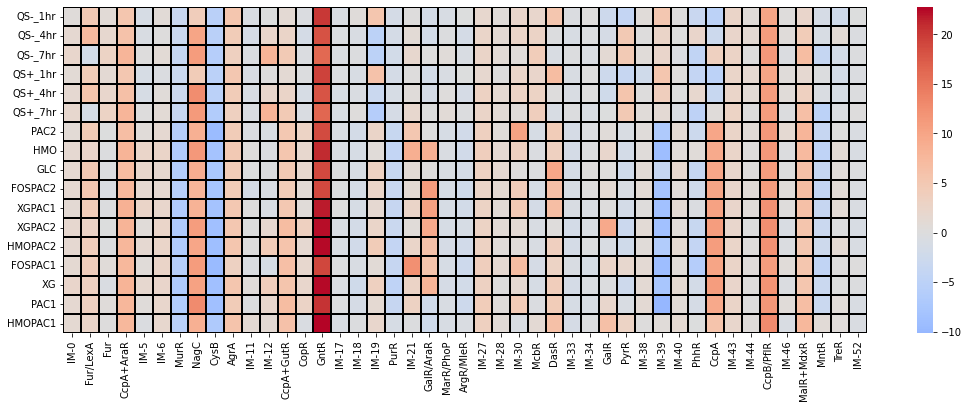

In [40]:
fig, ax = plt.subplots(1,1, figsize=(18,6))
sns.heatmap( A_merge, xticklabels=True, 
            linecolor='black',linewidths=1.5,cmap="coolwarm",center=0, ax = ax)
plt.savefig('../../../../ICA_LP/Figures/Amatrix_qs_cc.svg',format='svg',dpi=150)

In [83]:
labels = ['WCFS1_MRS', 'LB16_MRS', 'TJ', 'TJ', 'TJ', 
          'WFH', 'WFH','WFH','PJ', 'PJ', 'PJ', 'DE', 'DE', 'DE', 'FE','FE', 'FE', 'FE', 'FE',
          'FE', 'BEE', 'BEE','BEE', 'OE', 'OE', 'OE', 'CB',
          'X_MRS', 'X_MRS','X_MRS', 'X_MRS', 'X_MRS', 'X_MRS', 'X_MRS', 'X_MRS',
       'X_MRS']
np.unique(labels)
color_dict = {'WCFS1_MRS':'lime','LB16_MRS':'tab:green','BEE':'tab:orange', 'CB':'hotpink', 'DE':'tab:gray', 'FE':'tab:brown', 
             'OE':'tab:olive', 'PJ':'coral', 'TJ':'tomato', 'WFH':'wheat', 'X_MRS':'tab:blue'}
colors = [ color_dict[l] for l in labels ]

In [84]:
def add_linear(ax, xdata, ydata):
    def func(x, a, b):
        return a * x + b
    popt, pcov = curve_fit(func, xdata, ydata)
    temp_x = np.linspace(min(xdata),max(xdata) )
    ax.plot(temp_x, func(temp_x, *popt),'r--')
    
def scatter(ax, x,y,colors):
    for i in range(len(x)):
        ax.scatter(x[i],y[i],c=colors[i])
    
  

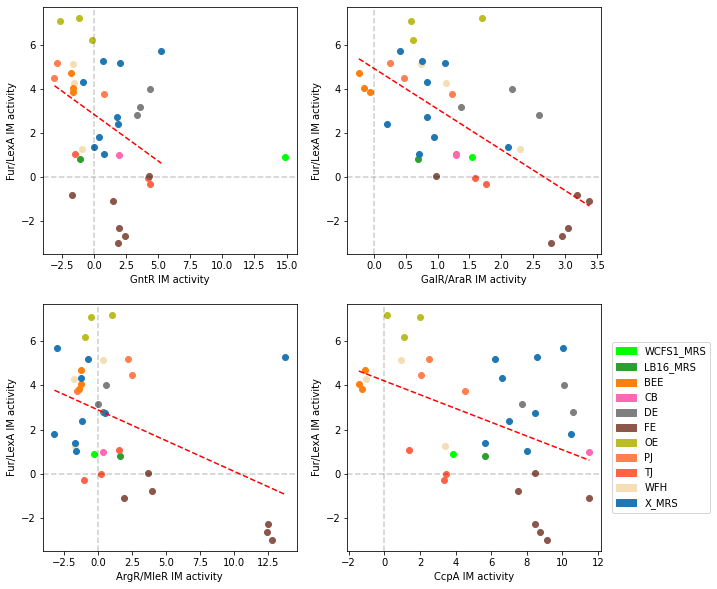

In [87]:
A_hab = A[ A.columns[42:78] ]
fig, axs = plt.subplots(2,2, figsize=(10,10))
scatter(axs[0][0], A_hab.loc[16], A_hab.loc[1],colors)
axs[0][0].set_xlabel('GntR IM activity')
add_linear(axs[0][0], A_hab.loc[16][1:], A_hab.loc[1][1:])

scatter(axs[0][1], A_hab.loc[23], A_hab.loc[1],colors)
add_linear(axs[0][1], A_hab.loc[23], A_hab.loc[1])
axs[0][1].set_xlabel('GalR/AraR IM activity')

scatter(axs[1][0], A_hab.loc[26], A_hab.loc[1],colors)
axs[1][0].set_xlabel('ArgR/MleR IM activity')
add_linear(axs[1][0], A_hab.loc[26], A_hab.loc[1])

scatter(axs[1][1], A_hab.loc[42], A_hab.loc[1],colors)
axs[1][1].set_xlabel('CcpA IM activity')
add_linear(axs[1][1], A_hab.loc[42], A_hab.loc[1])
handles = []
for cond in color_dict.keys():
    handles.append( mpatches.Patch(color= color_dict[cond], label=cond))
axs[1][1].legend(handles=handles,loc='right',bbox_to_anchor=[1.45, 0.5])   
    

for i in range(2):
    for j in range(2):
        axs[i][j].set_ylabel('Fur/LexA IM activity')
        axs[i][j].axhline(y=0, color='black', linestyle='--',alpha=0.2)
        axs[i][j].axvline(x=0, color='black', linestyle='--',alpha=0.2)